Мы импортируем необходимые модули и пакеты: numpy, tensorflow, matplotlib и прочие. Устанавливается переменная окружения KMP_DUPLICATE_LIB_OK в значение "TRUE". Это может быть необходимо на некоторых системах, чтобы избежать ошибки повторного дублирования библиотек.

In [1]:
import os
import pathlib

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Устанавливаем значение переменной эпох (для обучения использовалось порядка 250 эпох). Прописываем список классов, представляющих различные монеты - 11 видов монет. Определяется переменная data_dir, содержащая путь к каталогу с набором данных. Здесь используется модуль pathlib, чтобы получить объект Path, представляющий путь к каталогу ./datasets/coins. Определяются дополнительные параметры для обучения модели: batch_size и размеры изображения.

In [3]:
EPOCHS = 250
MODEL_NAME = "coindet"
CLASSES = ['100rub', '10kop', '10rub', '1kop', '1rub', '25rub', '2rub', '3rub', '50kop', '5kop', '5rub']

data_dir = pathlib.Path("/content/drive/MyDrive/datasets/coins")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

batch_size = 32
img_height = 224
img_width = 224

1183


Используется функция для создания набора данных из изображений, расположенных в датасете, для обучения модели. Прописываем ей нужные параметры:


*   data_dir: путь к каталогу с изображениями
*   validation_split: доля данных, которая будет использоваться в качестве набора валидации (в данном случае, 20% данных)
*   subset: указывает, какую часть набора данных использовать
*   seed: определяет случайное распределение данных при разделении на обучающую и валидационную выборки.
*   image_size: размер изображений, к которому будут приведены все входные изображения
*   batch_size: размер пакета данных, который будет использоваться при обучении







In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1183 files belonging to 11 classes.
Using 947 files for training.


In [5]:
class_names = train_ds.class_names
print(class_names)

['100rub', '10kop', '10rub', '1kop', '1rub', '25rub', '2rub', '3rub', '50kop', '5kop', '5rub']


Такая же функция, но для валидации

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1183 files belonging to 11 classes.
Using 236 files for validation.


Валидационный набор данных val_ds и обучающий набор данных train_ds кэшируется с помощью cache() и предзагружается с помощью prefetch(). Создается слой нормализации normalization_layer, который будет преобразовывать значения пикселей из диапазона [0, 255] в диапазон [0, 1]. Применяем слой нормализации к каждому изображению в наборе данных.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [9]:
num_classes = 11

Проводим аугментацию данных. Аугментация данных - это процесс применения случайных преобразований к обучающим изображениям для увеличения разнообразия данных и повышения устойчивости модели.

In [10]:
data_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal",
                                   input_shape=(img_height,
                                                img_width,
                                                3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(.5, .2, interpolation='nearest'),
        tf.keras.layers.RandomContrast([1.0, 10.0]),
        tf.keras.layers.RandomBrightness(factor=0.2)
    ]
)

Определяем модель нейронной сети, составленной вручную, состоит из 15 слоев. 

In [11]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


Задаем конфигурацию компиляцию модели нейросети перед обучением. Эти параметры компиляции определяют, как модель будет обучаться и оцениваться во время тренировки.

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Выполняем процесс обучения модели нейронной сети на обучающих данных train_ds и оцениваес ее производительности на валидационных данных val_ds в течение заданного числа эпох.

In [13]:
history = model.fit(
      train_ds, 
      validation_data=val_ds, 
      epochs=EPOCHS
)

Epoch 1/250
30/30 [==============================] - 47s 1s/step - loss: 2.2934 - accuracy: 0.1763 - val_loss: 2.2079 - val_accuracy: 0.2034
Epoch 2/250
30/30 [==============================] - 1s 47ms/step - loss: 2.1992 - accuracy: 0.2070 - val_loss: 2.2088 - val_accuracy: 0.2034
Epoch 3/250
30/30 [==============================] - 1s 49ms/step - loss: 2.1909 - accuracy: 0.2059 - val_loss: 2.2617 - val_accuracy: 0.2034
Epoch 4/250
30/30 [==============================] - 1s 50ms/step - loss: 2.1846 - accuracy: 0.2017 - val_loss: 2.2227 - val_accuracy: 0.2034
Epoch 5/250
30/30 [==============================] - 1s 44ms/step - loss: 2.1639 - accuracy: 0.2101 - val_loss: 2.2105 - val_accuracy: 0.2034
Epoch 6/250
30/30 [==============================] - 1s 47ms/step - loss: 2.1416 - accuracy: 0.2207 - val_loss: 2.1859 - val_accuracy: 0.2034
Epoch 7/250
30/30 [==============================] - 1s 48ms/step - loss: 2.0950 - accuracy: 0.2112 - val_loss: 2.1997 - val_accuracy: 0.2034
Epoch 8

Здесь мы проводим инференс модели на изображениях из директории "./test" и выводит предсказанный класс и уверенность модели для каждого изображения.

In [ ]:
for file in os.listdir("/content/drive/MyDrive/datasets/test"):
    img = tf.keras.utils.load_img(f"/content/drive/MyDrive/datasets/test/{file}", target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array / img_width, 0)

    predictions = model.predict(img_array, verbose=0)
    score = tf.nn.softmax(predictions[0])
    answer = CLASSES[np.argmax(score)]

    print(f"predict {answer} on {file} with {round(float(max(score) * 100), 2)} percents")


Следующий код позволяет сохранить и конвертировать модель.

In [ ]:
# Save the model
model.save(MODEL_NAME)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_NAME)  # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model
with open(f'${MODEL_NAME}.tflite', 'wb') as f:
    f.write(tflite_model)

Далее снимаем метрики для визуализации.

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

Строим графики, чтобы наглядно увидеть, как прошло обучение.

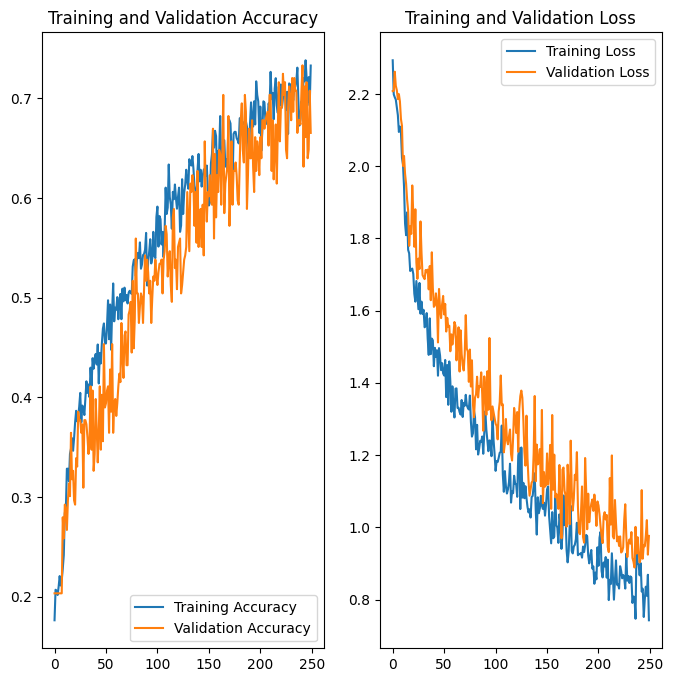

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()